## Import

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# Folder dataset disimpan
dataset_dir = r"..\dataset sinta haar\both eyes"

## Preprocessing

### From dataset folder

In [2]:
# List label
class_names = []

# Fitur dan label
features = []
labels = []

# Dimensi gambar
image_size = (149, 37)

In [ ]:
# Mengakses folder dataset
for path, subdirs, files in os.walk(dataset_dir):

    # Memilih jumlah dataset
    num_files = len(files)
    # Ganti 1 sesuai jumlah yang diinginkan (ex. 0.3) 
    num_to_select = int(num_files * 1) 
    selected_files = random.sample(files, num_to_select)
        
    # Mengakses file, resize, normalisasi, dan labeling
    for name in tqdm(selected_files):
        img_path = os.path.join(path, name)
        if img_path.endswith("png"):
            image_read = cv2.imread(img_path)
            image_resized = cv2.resize(image_read, image_size)
            image_normalized = image_resized / 255.0
            
            path_parts = path.split('\\')
            label = path_parts[-1]
            
            if label not in class_names:
                class_names.append(label)
            
            features.append(image_normalized)
            index = class_names.index(label)
            labels.append(index)

# Meruabah fitur dan label menjadi array numpy    
features = np.asarray(features)
labels = np.asarray(labels)

In [ ]:
# Menampilkan list label
print(class_names)

### From numpy data

In [3]:
features = np.load('/kaggle/input/drowsy-face/features.npy')
labels = np.load('/kaggle/input/drowsy-face/labels.npy')
class_names = ['Drowsy', 'Non Drowsy']

## Show data

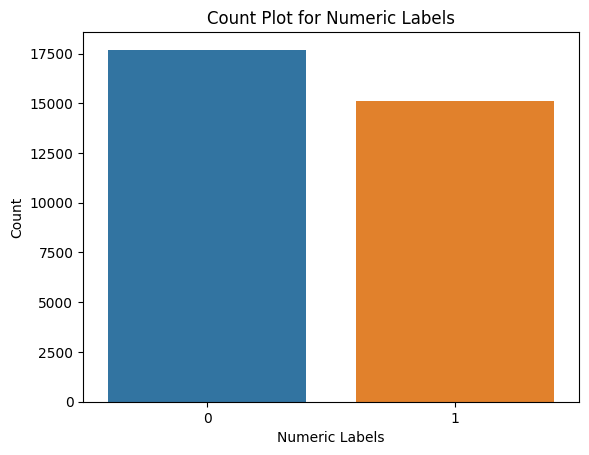

In [4]:
# Visualisasikan dalam jumlah dalam plot
sns.countplot(x = labels)
plt.xlabel('Numeric Labels')
plt.ylabel('Count')
plt.title('Count Plot for Numeric Labels')
plt.show()

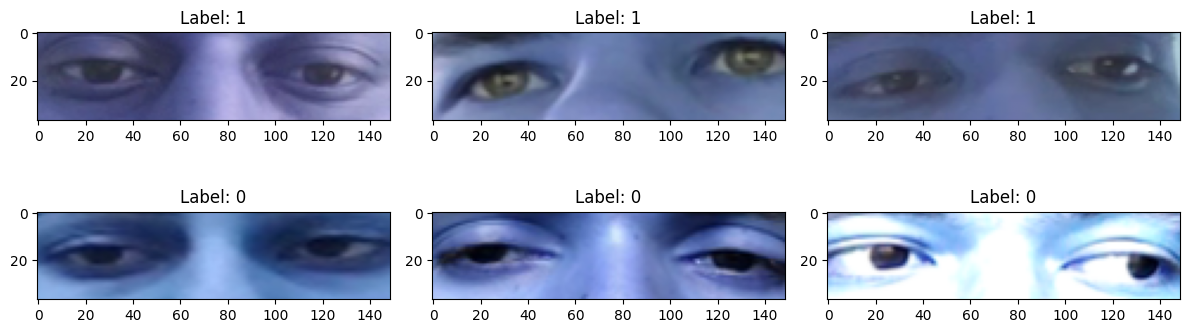

In [5]:
random_indices = np.random.choice(len(features), 6, replace=False)

# Plot the images
plt.figure(figsize=(12, 4))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(features[idx])
    plt.title("Label: " + str(labels[idx]))
plt.tight_layout()
plt.show()

## Flatten data

In [6]:
print(f"awal {features.shape}")

jml_data = features.shape[0]
h = features.shape[1]
w = features.shape[2]
d = features.shape[3]
flatten  = h*w*d
#untuk shape ML itu 1 dimensi jadi features 3 dimensi harus di reshape jadi 1dimensi
features_flatten = features.reshape(jml_data, flatten)

print(f"akhir {features_flatten.shape}")

awal (32791, 37, 149, 3)
akhir (32791, 16539)


## Split data

In [7]:
# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(features_flatten, labels, test_size=0.2, shuffle=True, random_state=42, stratify=labels)

print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))

X_train: (26232, 16539)
X_test: (6559, 16539)
y_train: (26232,)
y_test: (6559,)


In [8]:
# Melepaskan memori dengan menghapus variabel tidak terpakai
del features
del labels

## KNN

In [9]:
# Create a KNN
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [10]:
# Menampilkan classification report
y_pred = clf.predict(X_test)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

      Drowsy     0.9969    0.9997    0.9983      3538
  Non Drowsy     0.9997    0.9964    0.9980      3021

    accuracy                         0.9982      6559
   macro avg     0.9983    0.9980    0.9982      6559
weighted avg     0.9982    0.9982    0.9982      6559



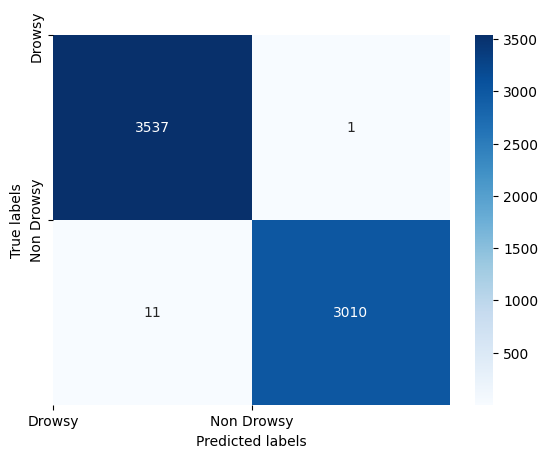

In [11]:
# Menampilkan confussion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

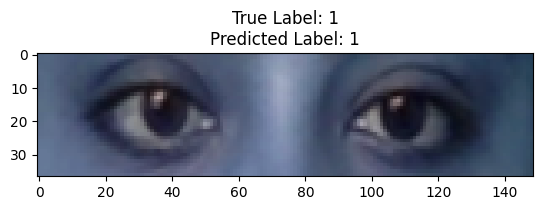

In [12]:
test_image = X_test[2]

# Make a prediction for the selected image
predicted_label = clf.predict([test_image])[0]

# Get the true label for the selected image
true_label = y_test[0]

# Display the image
plt.imshow(test_image.reshape(image_size[1], image_size[0], 3))
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.show()

## KNN with GridSearchCV

In [13]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

In [14]:
# Create a GridSearchCV object
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=10, verbose=4)

In [15]:
# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train a Decision Tree Classifier with the best parameters
best_clf = KNeighborsClassifier(**best_params)
best_clf.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END ...n_neighbors=3, weights=uniform;, score=0.999 total time=  33.1s
[CV 2/10] END ...n_neighbors=3, weights=uniform;, score=0.998 total time=  32.4s
[CV 3/10] END ...n_neighbors=3, weights=uniform;, score=0.999 total time=  32.8s
[CV 4/10] END ...n_neighbors=3, weights=uniform;, score=0.998 total time=  32.9s
[CV 5/10] END ...n_neighbors=3, weights=uniform;, score=0.999 total time=  32.8s
[CV 6/10] END ...n_neighbors=3, weights=uniform;, score=1.000 total time=  32.9s
[CV 7/10] END ...n_neighbors=3, weights=uniform;, score=0.998 total time=  32.7s
[CV 8/10] END ...n_neighbors=3, weights=uniform;, score=0.998 total time=  32.4s
[CV 9/10] END ...n_neighbors=3, weights=uniform;, score=0.999 total time=  32.4s
[CV 10/10] END ..n_neighbors=3, weights=uniform;, score=1.000 total time=  32.6s
[CV 1/10] END ..n_neighbors=3, weights=distance;, score=0.999 total time=  32.8s
[CV 2/10] END ..n_neighbors=3, weights=distance;

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [16]:
# Menampilkan classification report
y_pred = best_clf.predict(X_test)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

      Drowsy     0.9983    0.9997    0.9990      3538
  Non Drowsy     0.9997    0.9980    0.9988      3021

    accuracy                         0.9989      6559
   macro avg     0.9990    0.9989    0.9989      6559
weighted avg     0.9989    0.9989    0.9989      6559



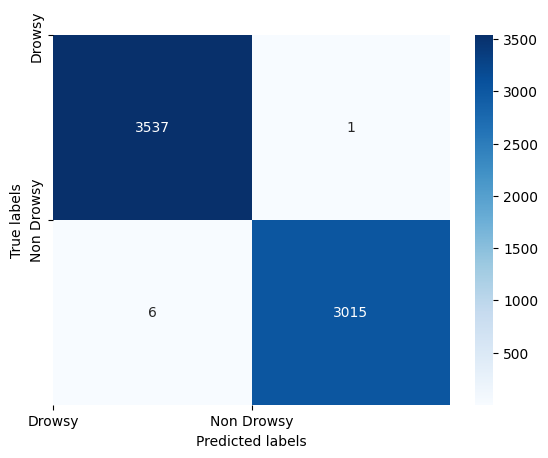

In [17]:
# Menampilkan confussion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

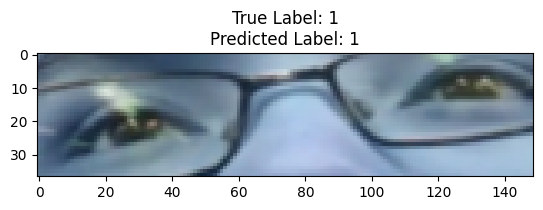

In [18]:
test_image = X_test[0]

# Make a prediction for the selected image
predicted_label = best_clf.predict([test_image])[0]

# Get the true label for the selected image
true_label = y_test[0]

# Display the image
plt.imshow(test_image.reshape(image_size[1], image_size[0], 3))
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.show()

## Save Model

In [19]:
# Simpan model GridSearchCV terbaik
joblib.dump(best_clf, 'best_knn_model.pkl')

['best_knn_model.pkl']